<a href="https://colab.research.google.com/github/KillerStrike17/10DaysofMLChallenge/blob/master/Day6/Day_6_Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day6


## Import Libraries

In [1]:
!nvidia-smi

Wed Apr  1 00:12:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
#Summoning the Gods!!
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,SpatialDropout2D
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping,LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from sklearn.metrics import accuracy_score, confusion_matrix,multilabel_confusion_matrix

In [3]:
# Code to Mount drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Data Load and Extraction

In [0]:
!ls
!cp kaggle.json ../root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/content/.kaggle/kaggle.json': No such file or directory


In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [0]:
!ls

chest-xray-pneumonia.zip  gdrive  kaggle.json  sample_data


In [0]:
!cp /content/chest-xray-pneumonia.zip /content/gdrive/My\ Drive/Kaggle_Competitions_Dataset/Pnemonia_Classification

In [0]:
!cp /content/gdrive/My\ Drive/Kaggle_Competitions_Dataset/Pnemonia_Classification/chest-xray-pneumonia.zip /content

In [5]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [0]:
data_dir = pathlib.Path('/content/chest_xray/chest_xray/train')

In [7]:
!cd chest_xray/chest_xray/train/NORMAL/ && ls -1 | wc -l
!cd chest_xray/chest_xray/train/PNEUMONIA/ && ls -1 | wc -l
!cd chest_xray/train/NORMAL/ && ls -1 | wc -l
!cd chest_xray/train/PNEUMONIA/ && ls -1 | wc -l
# !ls

1341
3875
1341
3875


In [8]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if (item.name != "LICENSE.txt" and item.name != '.DS_Store')])
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

In [0]:
datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.3, vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_it = datagen.flow_from_directory('chest_xray/chest_xray/train/',  batch_size=64,classes = list(CLASS_NAMES),class_mode='categorical',target_size=(150,150))
# load and iterate validation dataset
val_it = val_datagen.flow_from_directory('chest_xray/chest_xray/test/', batch_size=64,classes = list(CLASS_NAMES),class_mode='categorical',target_size=(150,150))
val_it2 = val_datagen.flow_from_directory('chest_xray/chest_xray/val/', batch_size=64,classes = list(CLASS_NAMES),class_mode='categorical',target_size=(150,150))
# load and iterate test dataset

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

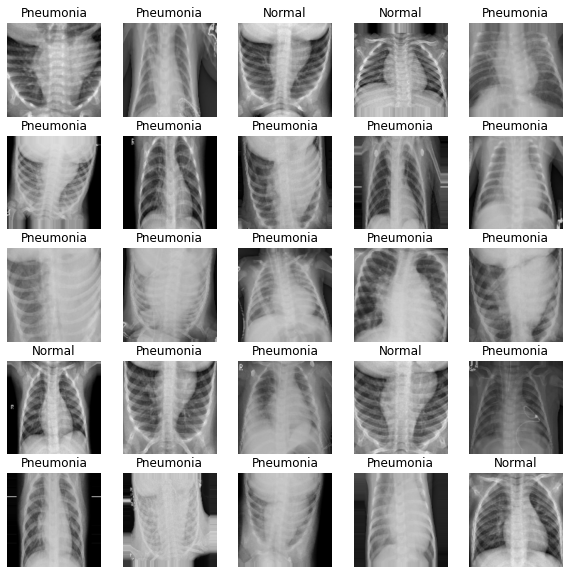

In [12]:
image_batch, label_batch = next(train_it)
show_batch(image_batch, label_batch)

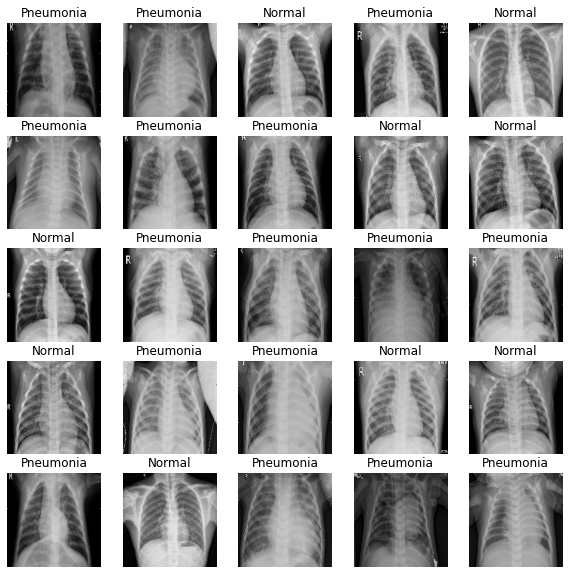

In [13]:
image_batch, label_batch = next(val_it)
show_batch(image_batch, label_batch)

In [14]:
print(image_batch.shape,image_batch.dtype)
print(label_batch.shape,label_batch.dtype)

(64, 150, 150, 3) float32
(64, 2) float32


In [15]:
train_it = datagen.flow_from_directory('chest_xray/chest_xray/train/',  batch_size=64,classes = list(CLASS_NAMES),class_mode='binary',target_size=(150,150))
# load and iterate validation dataset
val_it = val_datagen.flow_from_directory('chest_xray/chest_xray/test/', batch_size=64,classes = list(CLASS_NAMES),class_mode='binary',target_size=(150,150))
val_it2 = val_datagen.flow_from_directory('chest_xray/chest_xray/val/', batch_size=64,classes = list(CLASS_NAMES),class_mode='binary',target_size=(150,150))
# load and iterate test dataset

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
# One Cycle LR Implementation
def lr_schedule():
    
    def schedule(epoch):

      lr=lr1=np.interp([epoch],[0, 4,20], [0.0025, 0.005, 0])[0]
      print('epoch ', epoch+1, ': setting learning rate to ',lr1)
      return lr
    
    return LearningRateScheduler(schedule)

lr_sched = lr_schedule()

## Model Building

### Using Reduce LR

#### Model

In [0]:
img_dims = 150
epochs = 20
batch_size = 64

In [23]:

inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
# x = Flatten()(x)
x = Conv2D(filters=512,kernel_size = (1,1), activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Conv2D(filters=128,kernel_size = (1,1), activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Conv2D(filters=64,kernel_size = (1,1), activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = GlobalAveragePooling2D()(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

In [24]:
# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
# Callbacks

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_16 (Separab (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_17 (Separab (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_8 (Batch (None, 75, 75, 32)        128 

In [0]:
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


In [26]:
hist = model.fit_generator(
           train_it, steps_per_epoch=train_it.samples // batch_size, 
           epochs=epochs, validation_data=val_it, 
           validation_steps=val_it.samples // batch_size, callbacks=[lr_reduce,checkpoint])


Epoch 1/20
81/81 [==============================] - 78s 960ms/step - loss: 0.3780 - acc: 0.8234 - val_loss: 0.6620 - val_acc: 0.6285
Epoch 2/20
81/81 [==============================] - 76s 939ms/step - loss: 0.2654 - acc: 0.8884 - val_loss: 0.6843 - val_acc: 0.6285
Epoch 3/20
81/81 [==============================] - 76s 938ms/step - loss: 0.2364 - acc: 0.9070 - val_loss: 0.6812 - val_acc: 0.6285
Epoch 4/20
81/81 [==============================] - 76s 933ms/step - loss: 0.2170 - acc: 0.9092 - val_loss: 0.7154 - val_acc: 0.6285
Epoch 5/20
81/81 [==============================] - 76s 935ms/step - loss: 0.2007 - acc: 0.9179 - val_loss: 0.7370 - val_acc: 0.6285
Epoch 6/20
81/81 [==============================] - 74s 917ms/step - loss: 0.1927 - acc: 0.9241 - val_loss: 1.0179 - val_acc: 0.6285
Epoch 7/20
81/81 [==============================] - 74s 917ms/step - loss: 0.1637 - acc: 0.9404 - val_loss: 1.3324 - val_acc: 0.6285
Epoch 8/20
81/81 [==============================] - 73s 901ms/step - 

#### Model Validate

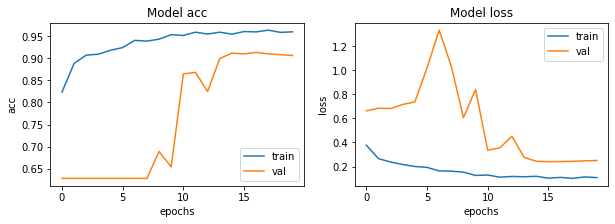

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_c' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [0]:
image_batch, label_batch = next(val_it)

In [0]:
preds = model.predict(image_batch)

In [37]:
preds

array([[1.0420382e-03],
       [8.8518292e-02],
       [1.3978231e-01],
       [1.3589442e-02],
       [9.5638132e-01],
       [8.2910061e-05],
       [9.1568053e-01],
       [1.0888693e-01],
       [9.3232244e-01],
       [9.7174370e-01],
       [9.5496488e-01],
       [6.7340726e-01],
       [3.4111738e-04],
       [3.1973004e-02],
       [3.0315518e-03],
       [8.8486016e-02],
       [9.5747226e-01],
       [6.7281723e-04],
       [1.4544159e-02],
       [1.9147605e-02],
       [3.0755997e-05],
       [6.7246258e-03],
       [7.5802952e-02],
       [4.9140155e-03],
       [8.8475078e-01],
       [1.4972979e-01],
       [8.7984872e-01],
       [9.8172152e-01],
       [2.2199750e-04],
       [9.1652739e-01],
       [8.4547997e-01],
       [6.3157082e-04],
       [4.1973591e-04],
       [2.9376179e-02],
       [3.8224459e-04],
       [3.5199523e-04],
       [9.9893510e-03],
       [1.2963802e-02],
       [3.0617321e-01],
       [2.0512938e-04],
       [8.2951784e-04],
       [3.478281

In [38]:
label_batch

array([0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.], dtype=float32)

In [39]:
acc = accuracy_score(label_batch, np.round(preds))*100
cm = confusion_matrix(label_batch, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))


CONFUSION MATRIX ------------------
[[39  0]
 [ 6 19]]

TEST METRICS ----------------------
Accuracy: 90.625%
Precision: 100.0%
Recall: 76.0%
F1-score: 86.36363636363636

TRAIN METRIC ----------------------
Train acc: 95.96


### Using OneCycle LR

#### Model

In [0]:
img_dims = 150
epochs = 20
batch_size = 64

In [49]:

inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
# x = Flatten()(x)
x = Conv2D(filters=512,kernel_size = (1,1), activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Conv2D(filters=128,kernel_size = (1,1), activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Conv2D(filters=64,kernel_size = (1,1), activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = GlobalAveragePooling2D()(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

In [50]:
# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
# Callbacks

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_32 (Separab (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_33 (Separab (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_16 (Batc (None, 75, 75, 32)        128 

In [0]:
checkpoint = ModelCheckpoint(filepath='best_weights2.hdf5', save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


In [52]:
hist = model.fit_generator(
           train_it, steps_per_epoch=train_it.samples // batch_size, 
           epochs=epochs, validation_data=val_it, 
           validation_steps=val_it.samples // batch_size, callbacks=[lr_sched,checkpoint])


epoch  1 : setting learning rate to  0.0025
Epoch 1/20
81/81 [==============================] - 78s 962ms/step - loss: 0.3545 - acc: 0.8344 - val_loss: 0.6623 - val_acc: 0.6285
epoch  2 : setting learning rate to  0.003125
Epoch 2/20
81/81 [==============================] - 75s 923ms/step - loss: 0.2757 - acc: 0.8841 - val_loss: 0.6836 - val_acc: 0.6285
epoch  3 : setting learning rate to  0.00375
Epoch 3/20
81/81 [==============================] - 74s 914ms/step - loss: 0.2702 - acc: 0.8849 - val_loss: 0.7121 - val_acc: 0.6285
epoch  4 : setting learning rate to  0.004375
Epoch 4/20
81/81 [==============================] - 73s 906ms/step - loss: 0.2586 - acc: 0.8939 - val_loss: 0.8184 - val_acc: 0.6285
epoch  5 : setting learning rate to  0.005
Epoch 5/20
81/81 [==============================] - 73s 901ms/step - loss: 0.2478 - acc: 0.8961 - val_loss: 0.4856 - val_acc: 0.6979
epoch  6 : setting learning rate to  0.0046875
Epoch 6/20
81/81 [==============================] - 72s 884ms/st

#### Model Validate

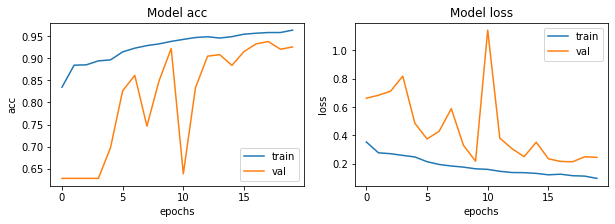

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [0]:
image_batch, label_batch = next(val_it)

In [0]:
preds = model.predict(image_batch)

In [57]:
preds

array([[8.6079681e-01],
       [7.3959666e-01],
       [6.1236322e-03],
       [2.0290613e-03],
       [8.0173993e-01],
       [8.9236611e-01],
       [3.0616283e-02],
       [5.8733791e-02],
       [7.1426868e-02],
       [3.1805933e-03],
       [8.9756399e-01],
       [8.8199973e-04],
       [8.5521936e-03],
       [4.3663263e-02],
       [2.3174176e-01],
       [5.6684631e-01],
       [8.9373201e-01],
       [5.0759614e-03],
       [4.0888101e-02],
       [1.3293922e-03],
       [1.6872236e-01],
       [8.7534040e-01],
       [6.1930019e-01],
       [3.2216996e-01],
       [7.5768530e-03],
       [5.9817523e-02],
       [3.7494600e-03],
       [8.8762939e-03],
       [7.4955499e-01],
       [1.6975343e-02],
       [5.4047674e-02],
       [8.3667135e-01],
       [8.5723400e-04],
       [3.6692828e-02],
       [2.9023165e-01],
       [9.3982452e-01],
       [3.0315608e-02],
       [6.9730222e-01],
       [6.6471779e-01],
       [9.2146361e-01],
       [4.9185455e-03],
       [8.186566

In [58]:
label_batch

array([1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.], dtype=float32)

In [59]:
acc = accuracy_score(label_batch, np.round(preds))*100
cm = confusion_matrix(label_batch, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))


CONFUSION MATRIX ------------------
[[29  0]
 [10 25]]

TEST METRICS ----------------------
Accuracy: 84.375%
Precision: 100.0%
Recall: 71.42857142857143%
F1-score: 83.33333333333333

TRAIN METRIC ----------------------
Train acc: 96.33
